In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

BATCH_SIZE = 1
FPS = 5
MAX_FRAMES = 1000

ROOT_DIR = "/content/drive/MyDrive/research"
FRAME_DIR = os.path.join('extracted_frames_5FPS')
DATA_DIR = os.path.join(ROOT_DIR, 'data')


In [ ]:
import os
import cv2

def extract_frames(video_path, target_fps):
    video = cv2.VideoCapture(video_path)
    original_fps = int(video.get(cv2.CAP_PROP_FPS))
    frame_interval = original_fps // target_fps
    count = 0
    success, image = video.read()
    frames = []
    while success:
        if count % frame_interval == 0:
            frames.append(image)
        success, image = video.read()
        count += 1
    video.release()
    return frames

def save_frames(frames, folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    for i, frame in enumerate(frames):
        frame_path = os.path.join(folder_path, f"frame_{i}.jpg")
        cv2.imwrite(frame_path, frame)

def process_directory(directory_path, output_path, target_fps=FPS):
    for category in ['shoplifting videos', 'normal videos']:
        category_path = os.path.join(directory_path, category)
        video_files = [os.path.join(category_path, f) for f in os.listdir(category_path)]

        for video_file in video_files:
            frames = extract_frames(video_file, target_fps)
            video_base_name = os.path.splitext(os.path.basename(video_file))[0]
            frame_folder = os.path.join(output_path, category, video_base_name)
            save_frames(frames, frame_folder)

if not os.path.exists(FRAME_DIR):
    for subset in ['train', 'test', 'validation']:
        process_directory(os.path.join(DATA_DIR, subset), os.path.join(FRAME_DIR, subset), target_fps=FPS)


In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence

class PyDataset(Sequence):
    def __init__(self, data_dir, batch_size=1, frame_size=(224, 224), max_sequence_length=100, **kwargs):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.frame_size = frame_size
        self.max_sequence_length = max_sequence_length
        self.classes = ['normal videos', 'shoplifting videos']
        self.file_paths = []
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(data_dir, class_name)
            videos = [os.path.join(class_dir, video) for video in os.listdir(class_dir)]
            for video in videos:
                frames = [os.path.join(video, fname) for fname in os.listdir(video) if fname.endswith('.jpg')]
                self.file_paths.append((frames, class_idx))
        self.on_epoch_end()
        super().__init__(**kwargs)

    def __len__(self):
        return (len(self.file_paths) + self.batch_size - 1) // self.batch_size  # Ensure rounding up

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_frames = []
        batch_labels = []
        for paths, label in batch_paths:
            frames = []
            total_frames = len(paths)
            frame_interval = max(1, total_frames // self.max_sequence_length)  # Downsample based on max_sequence_length
            for i in range(0, total_frames, frame_interval):
                if len(frames) >= self.max_sequence_length:
                    break
                frame = cv2.imread(paths[i])
                frame = cv2.resize(frame, self.frame_size)
                frame = tf.convert_to_tensor(frame, dtype=tf.float32) / 255.0  # Normalize to [0, 1]
                frames.append(frame)
            if len(frames) < self.max_sequence_length:
                frames.extend([tf.zeros(self.frame_size + (3,))] * (self.max_sequence_length - len(frames)))  # Padding with zeros
            batch_frames.append(tf.stack(frames))
            batch_labels.append(label)

        batch_frames = tf.stack(batch_frames)
        batch_labels = tf.convert_to_tensor(batch_labels, dtype=tf.int32)

        return batch_frames, batch_labels

    def on_epoch_end(self):
        np.random.shuffle(self.file_paths)

# Create data generators
train_gen = PyDataset(os.path.join(FRAME_DIR, 'train'), batch_size=BATCH_SIZE, max_sequence_length=MAX_FRAMES)
val_gen = PyDataset(os.path.join(FRAME_DIR, 'validation'), batch_size=BATCH_SIZE, max_sequence_length=MAX_FRAMES)
test_gen = PyDataset(os.path.join(FRAME_DIR, 'test'), batch_size=BATCH_SIZE, max_sequence_length=MAX_FRAMES)


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Input, Masking

# Load pre-trained feature extractor from TensorFlow Hub
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

class HubFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, feature_extractor_url, **kwargs):
        super(HubFeatureExtractor, self).__init__(**kwargs)
        self.feature_extractor = hub.KerasLayer(feature_extractor_url, trainable=False)

    @tf.function
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        height = tf.shape(inputs)[2]
        width = tf.shape(inputs)[3]
        channels = tf.shape(inputs)[4]

        # Reshape the inputs to combine batch and time dimensions
        inputs = tf.reshape(inputs, [-1, height, width, channels])
        # Extract features
        features = self.feature_extractor(inputs)
        # Reshape features back to (batch, time, feature_dim)
        feature_dim = tf.shape(features)[-1]
        features = tf.reshape(features, [batch_size, time_steps, feature_dim])
        return features


# Define the LSTM model
input_shape = (None, 224, 224, 3)
video_input = Input(shape=input_shape)

# Use the custom HubFeatureExtractor layer
x = Masking(mask_value=0.)(video_input)  # Mask padding
x = HubFeatureExtractor(feature_extractor_url)(x)
x = TimeDistributed(Dense(128, activation='relu'))(x)
x = LSTM(512, return_sequences=False)(x)
x = Dense(1, activation='sigmoid')(x)

rnn_model = Model(inputs=video_input, outputs=x)
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

rnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 224, 224,   0         
                              3)]                                
                                                                 
 masking (Masking)           (None, None, 224, 224,    0         
                             3)                                  
                                                                 
 hub_feature_extractor (Hub  (None, None, 2048)        23564800  
 FeatureExtractor)                                               
                                                                 
 time_distributed (TimeDist  (None, None, 128)         262272    
 ributed)                                                        
                                                                 
 lstm (LSTM)                 (None, 512)               131276

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(os.path.join(ROOT_DIR, 'models', 'model_a_1_5FPS.keras' ), save_best_only=True)


# # Specify that you want to use the GPU
# if tf.config.list_physical_devices('GPU'):
#     with tf.device('GPU:0'):
#         history = rnn_model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[checkpoint_cb])
# else:
#     print("No GPU available, using CPU.")

history = rnn_model.fit(train_gen, validation_data=val_gen, epochs=20, callbacks=[checkpoint_cb])


Epoch 1/20
84/84 [==============================] - 418s 4s/step - loss: 0.8301 - accuracy: 0.4881 - val_loss: 0.6610 - val_accuracy: 0.5556
Epoch 2/20
84/84 [==============================] - 365s 4s/step - loss: 0.6608 - accuracy: 0.5238 - val_loss: 0.7425 - val_accuracy: 0.5000
Epoch 3/20
84/84 [==============================] - 364s 4s/step - loss: 0.6376 - accuracy: 0.5000 - val_loss: 0.8241 - val_accuracy: 0.4444
Epoch 4/20
84/84 [==============================] - 364s 4s/step - loss: 0.6372 - accuracy: 0.5119 - val_loss: 0.8326 - val_accuracy: 0.4444
Epoch 5/20
84/84 [==============================] - 365s 4s/step - loss: 0.6369 - accuracy: 0.5119 - val_loss: 0.8363 - val_accuracy: 0.5000
Epoch 6/20
84/84 [==============================] - 367s 4s/step - loss: 0.6363 - accuracy: 0.4643 - val_loss: 0.8433 - val_accuracy: 0.4444
Epoch 7/20
84/84 [==============================] - 365s 4s/step - loss: 0.6360 - accuracy: 0.5476 - val_loss: 0.8529 - val_accuracy: 0.4444
Epoch 8/20
84

In [ ]:
import pickle

# Save the history
with open(os.path.join(ROOT_DIR,'models','model_a_1_5FPS.pkl'), 'wb') as file:
    pickle.dump(history.history, file)

# Load the history
with open(os.path.join(ROOT_DIR,'models','model_a_1_5FPS.pkl'), 'rb') as file:
    history = pickle.load(file)

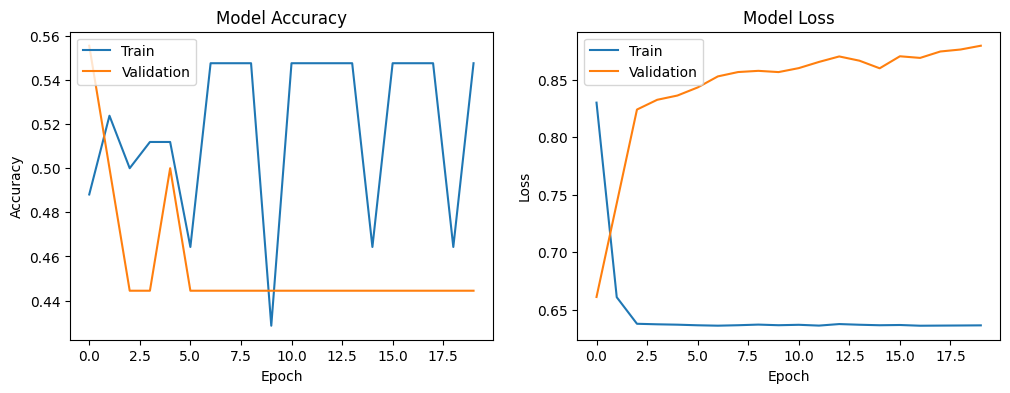

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
# Evaluate the model
test_loss, test_acc = rnn_model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')


18/18 [==============================] - 62s 3s/step - loss: 0.6933 - accuracy: 0.5000
Test Loss: 0.6932879686355591
Test Accuracy: 0.5


In [ ]:
import tensorflow as tf

# Load the saved model
model_path = os.path.join(ROOT_DIR, 'models','model_a_1_5FPS.keras')
loaded_model = tf.keras.models.load_model(model_path, custom_objects={'HubFeatureExtractor': HubFeatureExtractor})

In [ ]:
test_loss, test_acc = loaded_model.evaluate(test_gen)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

18/18 [==============================] - 64s 3s/step - loss: 0.6933 - accuracy: 0.5000
Test Loss: 0.6932548880577087
Test Accuracy: 0.5


In [ ]:
print("Training samples:", len(train_gen.file_paths))
print("Validation samples:", len(val_gen.file_paths))
print("Test samples:", len(test_gen.file_paths))

Training samples: 84
Validation samples: 18
Test samples: 18


In [ ]:
from collections import Counter

# Check distribution of classes in training data
train_labels = [label for _, label in train_gen.file_paths]
train_class_distribution = Counter(train_labels)
print("Training class distribution:", train_class_distribution)

# Use class weighting if necessary
class_weight = {0: 1.0, 1: train_class_distribution[0] / train_class_distribution[1]}
print("Class weight:", class_weight)

Training class distribution: Counter({1: 42, 0: 42})
Class weight: {0: 1.0, 1: 1.0}


Processing batch 1/18
1/1 [==============================] - 4s 4s/step
Batch Frames Shape: (1, 1000, 224, 224, 3)
Batch Labels Shape: (1,)
Predictions Shape: (1, 1)
Rounded Predictions: [1]
True Labels: [0]
Min Prediction: 0.508389 Max Prediction: 0.508389
Min Label: 0 Max Label: 0
Predictions Contain NaN: False
Labels Contain NaN: False
Processing batch 2/18
1/1 [==============================] - 3s 3s/step
Batch Frames Shape: (1, 1000, 224, 224, 3)
Batch Labels Shape: (1,)
Predictions Shape: (1, 1)
Rounded Predictions: [1]
True Labels: [1]
Min Prediction: 0.508389 Max Prediction: 0.508389
Min Label: 1 Max Label: 1
Predictions Contain NaN: False
Labels Contain NaN: False
Processing batch 3/18
1/1 [==============================] - 3s 3s/step
Batch Frames Shape: (1, 1000, 224, 224, 3)
Batch Labels Shape: (1,)
Predictions Shape: (1, 1)
Rounded Predictions: [1]
True Labels: [0]
Min Prediction: 0.508389 Max Prediction: 0.508389
Min Label: 0 Max Label: 0
Predictions Contain NaN: False
Lab

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


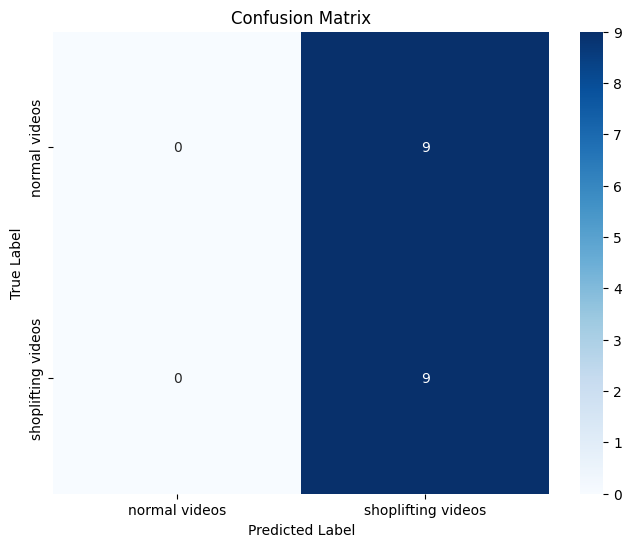

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize lists for predictions and true labels
y_pred = []
y_true = []

# Get the number of steps in the generator
num_steps = len(test_gen)

# Iterate over the test generator batches
for i, (batch_frames, batch_labels) in enumerate(test_gen):
    if i >= num_steps:
        break
    try:
        print(f"Processing batch {i+1}/{num_steps}")
        predictions = rnn_model.predict(batch_frames)  # Disable progress bar
        # Ensure predictions are in the range [0, 1]
        predictions = np.clip(predictions, 0, 1)
        # Round predictions to get binary outputs (0 or 1)
        rounded_predictions = np.round(predictions).astype(int).flatten()

        # Debugging Statements
        print("Batch Frames Shape:", batch_frames.shape)
        print("Batch Labels Shape:", batch_labels.shape)
        print("Predictions Shape:", predictions.shape)
        print("Rounded Predictions:", rounded_predictions)
        print("True Labels:", batch_labels.numpy().flatten())
        print("Min Prediction:", np.min(predictions), "Max Prediction:", np.max(predictions))
        print("Min Label:", np.min(batch_labels), "Max Label:", np.max(batch_labels))
        print("Predictions Contain NaN:", np.any(np.isnan(predictions)))
        print("Labels Contain NaN:", np.any(np.isnan(batch_labels.numpy())))

        y_pred.extend(rounded_predictions)
        y_true.extend(batch_labels.numpy().flatten())
    except Exception as e:
        print(f"Error processing batch {i+1}: {e}")
        break

# Convert lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true).astype(int)

# Classification report
print("Classification Report:")
try:
    print(classification_report(y_true, y_pred, target_names=test_gen.classes))
except ValueError as e:
    print("Error in classification_report:", e)

# Confusion matrix
print("Confusion Matrix:")
try:
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
except ValueError as e:
    print("Error in confusion_matrix:", e)

# Plot confusion matrix
if 'conf_matrix' in locals():
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.classes, yticklabels=test_gen.classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


In [ ]:
import cv2
import numpy as np

def load_and_preprocess_video(video_path, frame_size=(112, 112), num_frames=300):
    cap = cv2.VideoCapture(video_path)
    frames = []

    while cap.isOpened() and len(frames) < num_frames:
        ret, frame = cap.read()
        if not ret:
            break
        # Resize frame to the expected size
        frame = cv2.resize(frame, frame_size)
        # Normalize the frame to the range [0, 1]
        frame = frame / 255.0
        frames.append(frame)

    cap.release()

    # If the video is shorter than num_frames, pad with zeros
    if len(frames) < num_frames:
        padding = np.zeros((num_frames - len(frames), frame_size[0], frame_size[1], 3))
        frames = np.concatenate((frames, padding), axis=0)

    return np.array(frames)


In [ ]:
video_paths = os.listdir(os.path.join(DATA_DIR, 'test/normal videos'))

for video in video_paths:
    full_video_path = os.path.join(DATA_DIR, 'test/normal videos', video)
    video_frames = load_and_preprocess_video(full_video_path)
    video_frames = np.expand_dims(video_frames, axis=0)  # Add batch dimension

    # Make predictions on the video frames
    predictions = rnn_model.predict(video_frames)

    # Ensure predictions are in the range [0, 1]
    predictions = np.clip(predictions, 0, 1)
    # Round predictions to get binary outputs (0 or 1)
    rounded_predictions = np.round(predictions).astype(int).flatten()

    # binary classification: 0 = normal video, 1 = shoplifting video
    if rounded_predictions.mean() > 0.5:
        print("The video is classified as a shoplifting video.")
    else:
        print("The video is classified as a normal video.")

1/1 [==============================] - 8s 8s/step
The video is classified as a normal video.
1/1 [==============================] - 0s 74ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 76ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 79ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 75ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 73ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 73ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 72ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 73ms/step
The video is classified as a shoplifting video.


In [ ]:
video_paths = os.listdir(os.path.join(DATA_DIR, 'test/shoplifting videos'))
for video in video_paths:
    full_video_path = os.path.join(DATA_DIR, 'test/shoplifting videos', video)
    video_frames = load_and_preprocess_video(full_video_path)
    video_frames = np.expand_dims(video_frames, axis=0)  # Add batch dimension

    # Make predictions on the video frames
    predictions = rnn_model.predict(video_frames)

    # Ensure predictions are in the range [0, 1]
    predictions = np.clip(predictions, 0, 1)
    # Round predictions to get binary outputs (0 or 1)
    rounded_predictions = np.round(predictions).astype(int).flatten()

    # binary classification: 0 = normal video, 1 = shoplifting video
    if rounded_predictions.mean() > 0.5:
        print("The video is classified as a shoplifting video.")
    else:
        print("The video is classified as a normal video.")

1/1 [==============================] - 0s 72ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 72ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 71ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 72ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 74ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 72ms/step
The video is classified as a normal video.
1/1 [==============================] - 0s 70ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 71ms/step
The video is classified as a shoplifting video.
1/1 [==============================] - 0s 72ms/step
The video is classified as a shoplifting video.
